In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as nnf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import math
import cv2
from tqdm import tqdm

from sklearn.manifold import TSNE

workers = 0 if os.name == 'nt' else 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [2]:
# 범례 한글 깨짐 현상 해결
# https://ehpub.co.kr/47-matplotlib%EC%9D%98-rc%EC%97%90-%ED%95%9C%EA%B8%80-%ED%8F%B0%ED%8A%B8%EB%A5%BC-%EC%84%A4%EC%A0%95%ED%95%A0-%EC%88%98-%EC%9E%88%EC%96%B4%EC%9A%94/
# https://koosco.tistory.com/38
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# to_do_list : 각 폴더에 맞게 수정하면서 사용하다가 이후에 .py 파일로 변경시 상대경로로 바꿔야 할 듯!#

# data_path: 연예인 폴더들을 포함하는 상위 폴더
actor_data_path = "/opt/ml/embedding_visualization/data/actor_data"

# embedding_saving_path: embedding vector 변수가 저장되는 파일 위치
actor_embedding_saving_path = "/opt/ml/embedding_visualization/data/actor_embedding_saving.data"

# embedding_info_path: embedding vector에 해당하는 이미지 경로정보가 저장되는 파일 위치
actor_embedding_info_path = "/opt/ml/embedding_visualization/data/actor_embedding_info.data"

# resize_img_path : tensorboard에서 img visualization을 위해 사용하는 img가 저장되는 파일 위치
actor_tensorboard_img_path = "/opt/ml/embedding_visualization/data/actor_tensorboard_img.data"

# webtoon_data_path : 웹툰 폴더들을 포함하는 상위 폴더
webtoon_data_path = "/opt/ml/embedding_visualization/data/webtoon"

# embedding_saving_path: embedding vector 변수가 저장되는 파일 위치
webtoon_embedding_saving_path = "/opt/ml/embedding_visualization/data/webtoon_embedding_saving.data"

# embedding_info_path: embedding vector에 해당하는 이미지 경로정보가 저장되는 파일 위치
webtoon_embedding_info_path = "/opt/ml/embedding_visualization/data/webtoon_embedding_info.data"

# webtoon_img_path : tensorboard에서 webtoon img visualization을 위해 사용하는 img가 저장되는 파일 위치
webtoon_tensorboard_img_path = "/opt/ml/embedding_visualization/data/webtoon_tensorboard_img.data"

In [4]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [5]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [6]:
# actor_embeddings 로드
with open(actor_embedding_saving_path, 'rb') as f:
    actor_embeddings = pickle.load(f)
# actor_path_infos 로드
with open(actor_embedding_info_path, 'rb') as f:
    actor_path_infos = pickle.load(f)
# actor_tensorboard_img 로드
with open(actor_tensorboard_img_path, 'rb') as f:
    actor_tensorboard_img = pickle.load(f)

# webtoon_embeddings 로드
with open(webtoon_embedding_saving_path, 'rb') as f:
    webtoon_embeddings = pickle.load(f)
# webtoon_path_infos 로드
with open(webtoon_embedding_info_path, 'rb') as f:
    webtoon_path_infos = pickle.load(f)
# webtoon_tensorboard_img 로드
with open(webtoon_tensorboard_img_path, 'rb') as f:
    webtoon_tensorboard_img = pickle.load(f)

In [7]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/embedding_visualization')

2021-12-12 14:14:04.307687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/envs/lightweight/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-12-12 14:14:04.307725: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [9]:
# len(actor_embeddings) = 19702
actor_tensorboard_embeddings = torch.tensor(actor_embeddings[:200])
actor_tensorboard_img = actor_tensorboard_img[:200]
actor_tensorboard_names = [name for name,file_name in actor_path_infos[:200]]  

# len()
webtoon_tensorboard_embeddings = torch.tensor(webtoon_embeddings[:200])
webtoon_tensorboard_img = webtoon_tensorboard_img[:200]
webtoon_tensorboard_names = [name for name,file_name in webtoon_path_infos[:200]]

In [10]:
output_tensorboard_embeddings = torch.cat([actor_tensorboard_embeddings,webtoon_tensorboard_embeddings],dim = 0)
output_tensorboard_img = torch.cat([actor_tensorboard_img , webtoon_tensorboard_img],dim=0)
output_tensorboard_names = actor_tensorboard_names + webtoon_tensorboard_names

print(output_tensorboard_embeddings.shape)
print(np.shape(output_tensorboard_img))
print(np.shape(output_tensorboard_names))

torch.Size([400, 512])
torch.Size([400, 3, 50, 50])
(400,)


In [11]:
# # 265장 -> 1.6s
tsne = TSNE(2, verbose=-1)
tsne_proj = tsne.fit_transform(np.array(output_tensorboard_embeddings))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.384677
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.243225
[t-SNE] KL divergence after 1000 iterations: 0.499797


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
/opt/conda/envs/lightweight/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50980 (\N{HANGUL SYLLABLE YUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/lightweight/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/lightweight/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/lightweight/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44608 (\N{HANGUL SYLLABLE GIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda

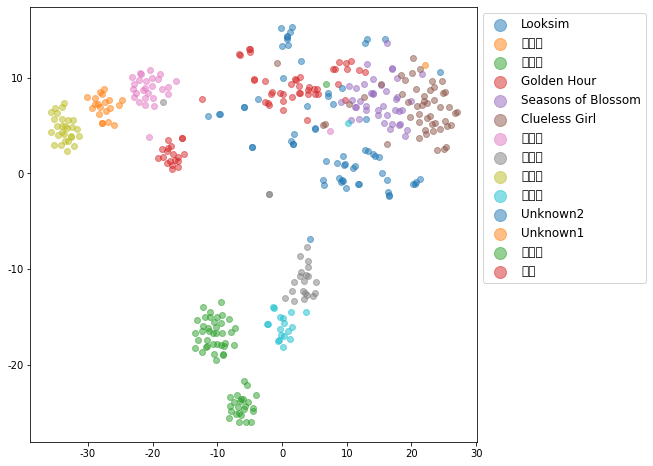

In [12]:
# 범례 한글 깨짐 현상 해결
# https://ehpub.co.kr/47-matplotlib%EC%9D%98-rc%EC%97%90-%ED%95%9C%EA%B8%80-%ED%8F%B0%ED%8A%B8%EB%A5%BC-%EC%84%A4%EC%A0%95%ED%95%A0-%EC%88%98-%EC%9E%88%EC%96%B4%EC%9A%94/
# https://koosco.tistory.com/38
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

num_categories = len(set(output_tensorboard_names))
cmap = matplotlib.cm.get_cmap('Set1', num_categories)

fig, ax = plt.subplots(figsize=(8,8))
for i,lab in enumerate(set(output_tensorboard_names)):
    indices = np.array(output_tensorboard_names)==lab
    # ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(i)).reshape(1,4), label = lab ,alpha=0.5)
    ax.scatter(tsne_proj[indices,0], tsne_proj[indices,1], cmap=cmap, label=lab ,alpha=0.5)


ax.legend(fontsize='large', markerscale=2, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [13]:
writer.add_embedding(output_tensorboard_embeddings, # 400명 embedding 결과
                    metadata=output_tensorboard_names,
                    label_img=output_tensorboard_img,
                    global_step=None
                    )
writer.close()

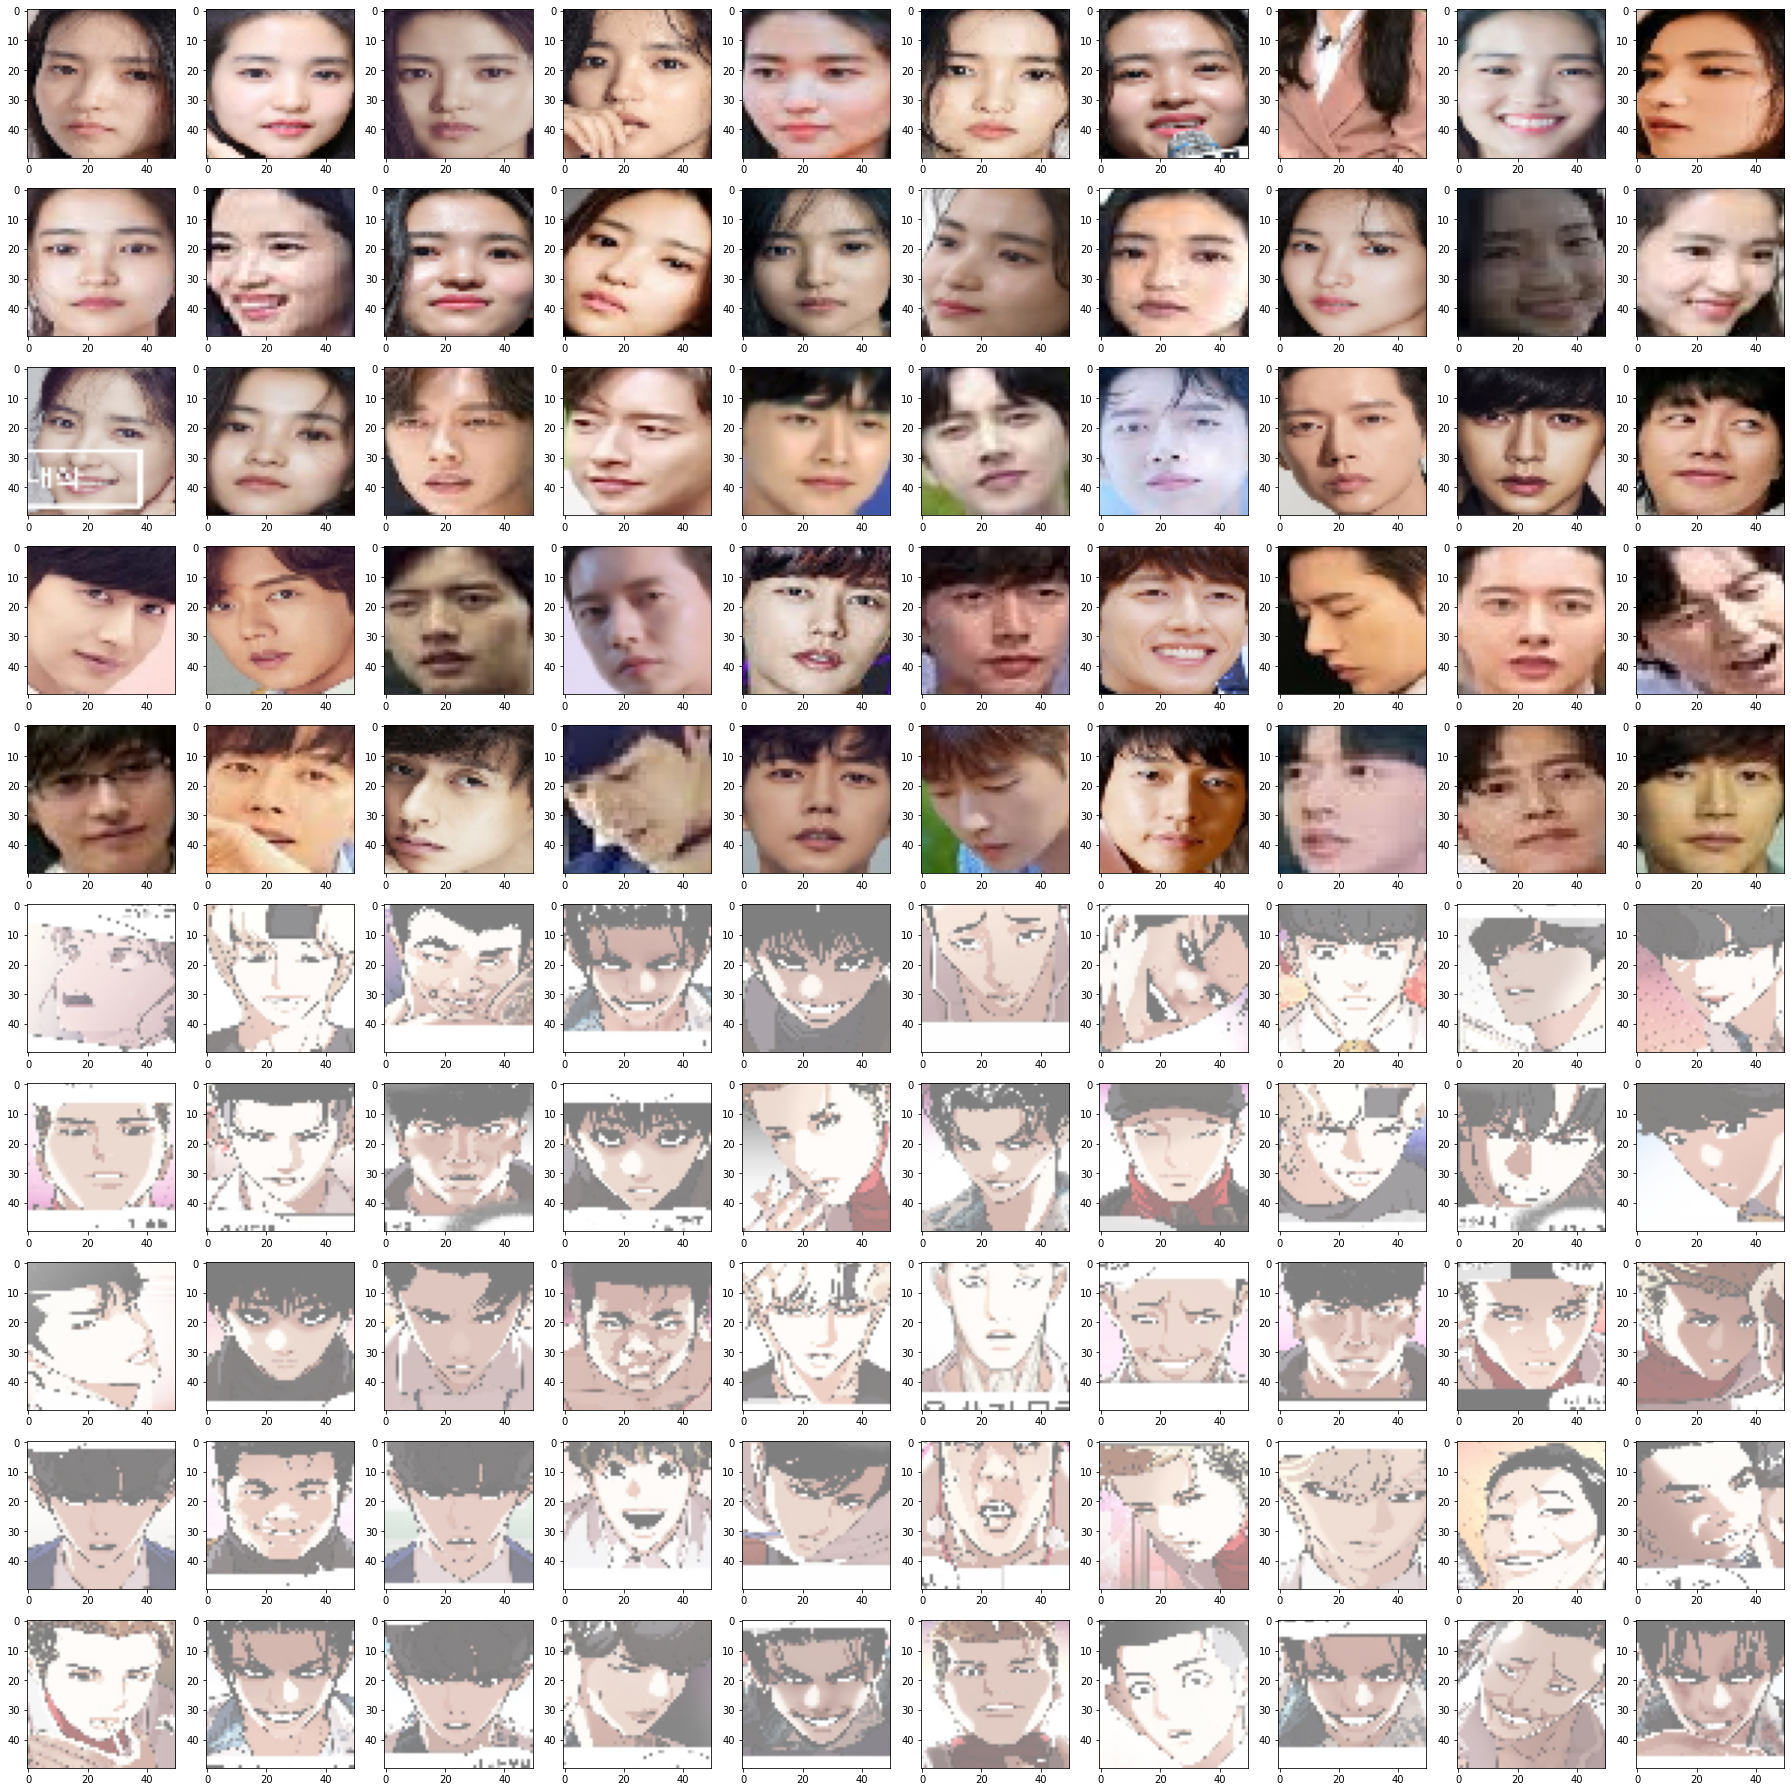

In [14]:
# crop된 face image 원본처럼 시각화 (MTCNN은 output을 normalize된 채로 output으로 내보냄!)
row_size = 10
col_size = min(10, math.ceil(len(output_tensorboard_img[:100])//row_size))
fig, ax = plt.subplots(row_size, col_size, figsize=(25, 25)) 
for i, output in enumerate(output_tensorboard_img[150:250]):
    ax[i//row_size][i%col_size].imshow((output * 128 + 127.5).cpu().numpy().astype(np.Uint64).transpose((1,2,0)))

fig.tight_layout()
plt.show()

In [15]:
import matplotlib as mpl

print(mpl.matplotlib_fname())

/opt/conda/envs/lightweight/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc


In [16]:
print(mpl.rcParams['font.family'])
print(mpl.rcParams['font.size'])

['NanumGothic']
10.0
